In [24]:
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt
from osgeo import ogr, gdal

In [14]:
# Need to load an image so we can extract the CRS
img = rxr.open_rasterio("/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/clean/ctxIMG_clipped.tif", cache=False)
shp_pathcust = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/subenvs_edited2.shp'

gdfcust = gpd.read_file(shp_pathcust)
gdfcust = gdfcust.to_crs(img.rio.crs)

for i in range(len(gdfcust)):
    if bool(gdfcust.iloc[i,5]):
        gdfcust.iloc[i,1] = gdfcust.iloc[i,5]
    if bool(gdfcust.iloc[i,4]):
        gdfcust.iloc[i,1] = "Custom"

gdfcust = gdfcust.drop(columns=['ansamai','Ambient','Feature'])
print("Number of unique subenvironments: ", len(gdfcust["SubEnv"].unique()))
print(gdfcust["SubEnv"].unique())

Number of unique subenvironments:  13
['Interdistributary_area' 'Channelized_area' 'Channelized_meander'
 'Delta_Front_FL' 'Delta_Front_WD' 'Interdistributary_bay' 'Delta_Front'
 'bottomsets' 'WC_Terrace' 'Custom' 'Crevasse Splay' 'Crater' 'Substratum']


In [15]:
col_nums = {'Interdistributary_area':1,
            'Channelized_area':2,
            'Channelized_meander':2,
            'Delta_Front_FL':3,
            'Delta_Front_WD':3,
            'Interdistributary_bay':1,
            'Delta_Front':3,
            'bottomsets':4,
            'WC_Terrace':4,
            'Crevasse Splay':1,
            'Crater':5,
            'Substratum':4,
            'Custom':4}


palette = {0 : (1, 1, 1), # Impervious surfaces (white)
           1 : (0, 0, 1), # Buildings (blue)
           2 : (0, 1, 1), # Low vegetation (cyan)
           3 : (0, 1, 0), # Trees (green)
           4 : (1, 1, 0), # Cars (yellow)
           5 : (1, 0, 0), # Clutter/background (red)
           6 : (0, 0, 0)} # Undefined (black)


color_nums = []
colors = []
for i in range(len(gdfcust)):
    num = col_nums[gdfcust.iloc[i,1]]
    color_nums.append(num)
    colors.append(palette[num])

gdfcust['color_num']=color_nums
gdfcust.head()

,OBJECTID,SubEnv,SHAPE_Leng,SHAPE_Area,geometry,color_num
0,1.0,Interdistributary_area,11745.225037,2.599315e+06,"POLYGON ((-1998218.671 -1412181.750, -1998214....",1
1,2.0,Interdistributary_area,1618.270728,1.368666e+05,"POLYGON ((-1994868.724 -1413604.072, -1994772....",1
2,3.0,Interdistributary_area,9222.632475,1.691370e+06,"POLYGON ((-1997450.774 -1411988.575, -1997450....",1
3,4.0,Interdistributary_area,6776.463240,1.420056e+06,"POLYGON ((-1995943.756 -1412006.178, -1995931....",1
4,5.0,Channelized_area,36608.027240,4.360505e+06,"POLYGON ((-1999418.612 -1411364.693, -1999418....",2


In [16]:
gdfcust.to_file('/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/subenvs_consolidated.shp')

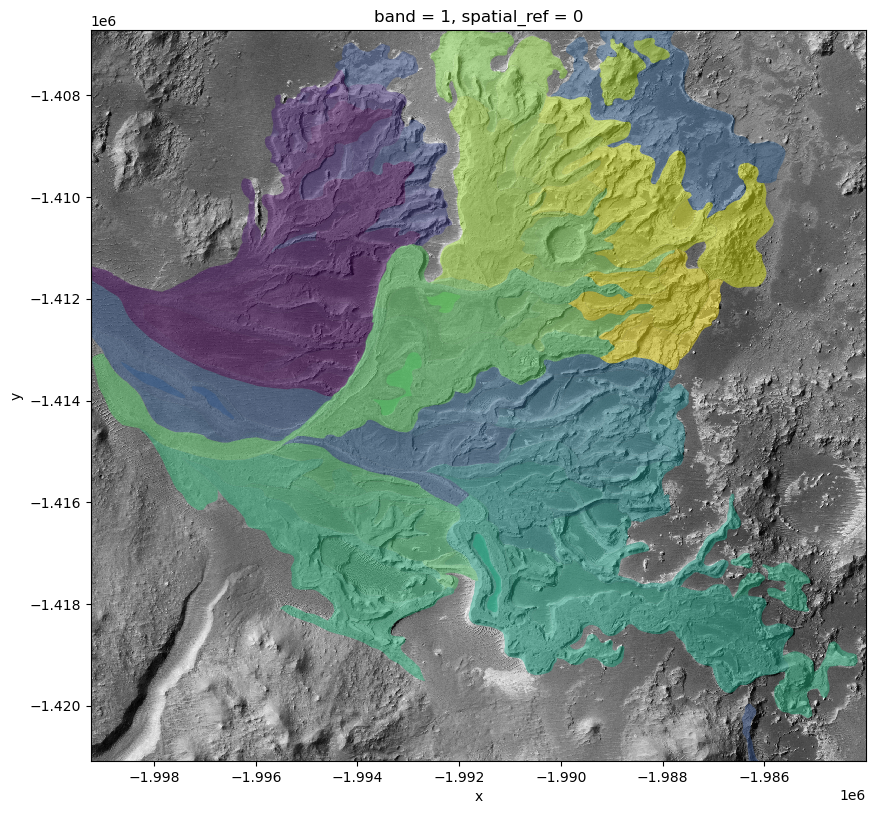

In [22]:
# Plot the image
fig, ax = plt.subplots(figsize=(10, 10))
img.plot(ax=ax, cmap='gray', add_colorbar=False)
gdfcust.plot(ax=ax, cmap='viridis', color=colors, alpha = 0.5)
plt.show()

In [25]:
def rasterize_shapefile_with_attribute(shapefile_path, match_raster_path, output_raster_path, attribute_field):
    # Open the data source and get the layer
    source_ds = ogr.Open(shapefile_path)
    source_layer = source_ds.GetLayer()

    # Open the match raster to get the geotransform and projection
    match_ds = gdal.Open(match_raster_path)
    geo_transform = match_ds.GetGeoTransform()
    projection = match_ds.GetProjection()
    x_res = match_ds.RasterXSize
    y_res = match_ds.RasterYSize

    # Create the destination data source
    target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_path, x_res, y_res, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    band = target_ds.GetRasterBand(1)
    band.SetNoDataValue(0)

    # Rasterize with attribute values
    gdal.RasterizeLayer(target_ds, [1], source_layer, options=["ATTRIBUTE=" + attribute_field])

    # Close the datasets
    target_ds = None
    source_ds = None
    match_ds = None

    print(f"Rasterized file saved as {output_raster_path}")


In [26]:
img_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/clean/ctxIMG_clipped.tif'
shp_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/subenvs_consolidated.shp'
out_path = '/Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif'
rasterize_shapefile_with_attribute(shp_path,img_path,out_path,'color_num')

Rasterized file saved as /Users/tthomas/Desktop/ESS569/MLGEO2024_MarsFans/data/label/validation_map.tif


In [ ]:
final_map = rxr.open_rasterio(out_path)

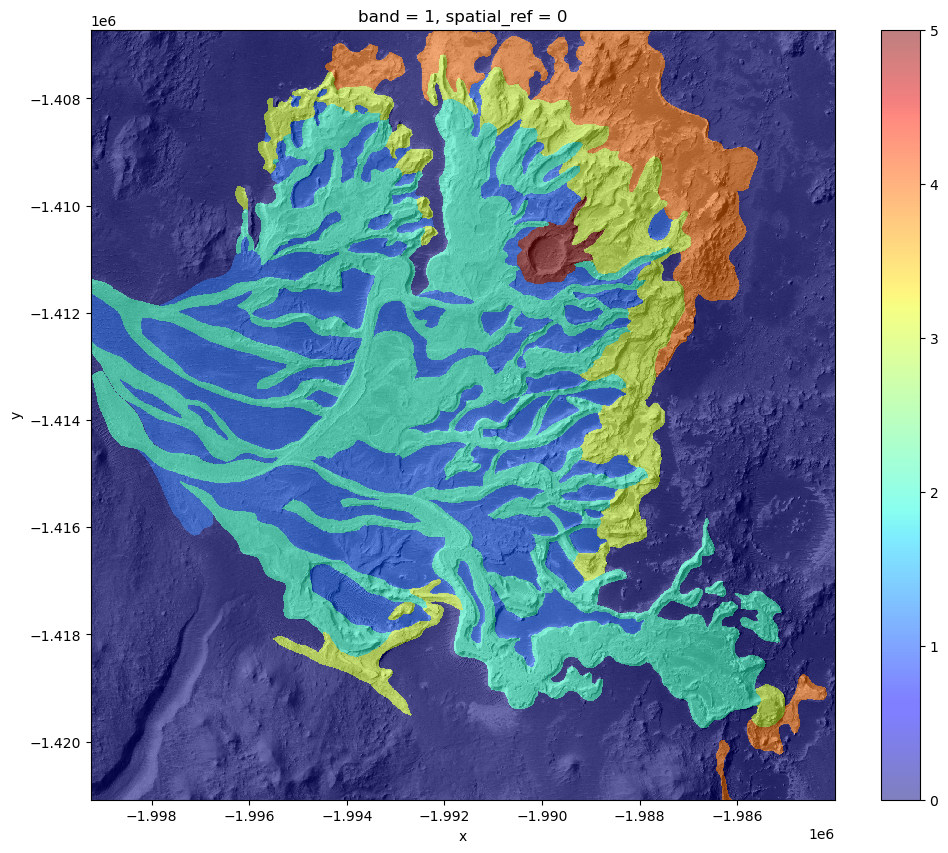

In [41]:
fig, ax = plt.subplots(figsize=(12, 10))
img.plot(ax=ax, cmap='gray', add_colorbar=False)
final_map.plot(ax=ax, cmap='jet', alpha = 0.5)
plt.show()